In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!rm -r "/content/vehicle_dataset/"
!cp '/content/drive/MyDrive/MIRCV/vehicle_dataset.zip' .
!unzip -q "/content/vehicle_dataset.zip"
!rm "/content/vehicle_dataset.zip"

rm: cannot remove '/content/vehicle_dataset/': No such file or directory


In [ ]:

GDRIVE_DIR = "/drive/MyDrive"
PROJECT=GDRIVE_DIR+"/MIRCV"
DATABASE=PROJECT+"/VeRi_with_plate"
TRAINING_SET="/content/vehicle_dataset/train"
VALIDATION_SET="/content/vehicle_dataset/valid"
TEST_SET="/content/vehicle_dataset/test"
BATCH_SIZE=128
CLASSES=9
IMAGE_SIZE=(224, 224)
dir_name =PROJECT+"/model/"

In [ ]:
import glob
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import math
from IPython.display import display
from tensorflow.keras.regularizers import l2
from tqdm.notebook import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import PIL
from tensorflow.keras.optimizers import RMSprop, Adam


np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def get_all_labels(dataset):
    number_of_examples = len(dataset.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 
    test_labels = []

    for i in tqdm(range(0,int(number_of_generator_calls))):
      test_labels.extend(np.array(dataset[i][1]))
    return np.int_(test_labels)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
train_datagen = image.ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=20,
            shear_range=20,
            #horizontal_flip=True
            )

test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

validation_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataset = train_datagen.flow_from_directory(
            TRAINING_SET,
            seed=123,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            shuffle=True)

valid_dataset = validation_datagen.flow_from_directory(
            VALIDATION_SET,
            seed=123,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            shuffle=True)

test_dataset = test_datagen.flow_from_directory(
        TEST_SET,
        shuffle=False,
        class_mode='sparse',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)



Found 17586 images belonging to 9 classes.
Found 4167 images belonging to 9 classes.
Found 11579 images belonging to 9 classes.


In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_dataset.classes),
    train_dataset.classes
)

In [ ]:
class_weights=dict(enumerate(class_weights))

(128, 224, 224, 3) (128,)
float32 -123.68 151.061


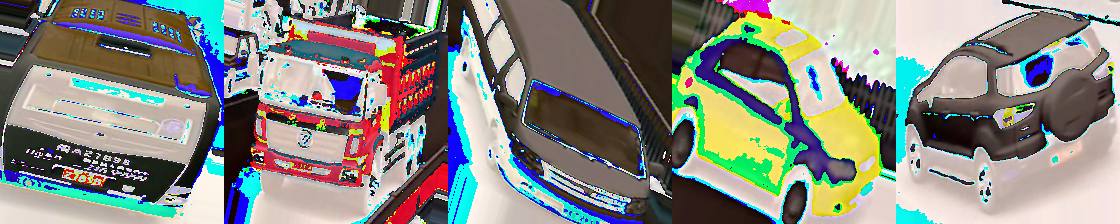

In [ ]:

# get the first batch from the streaming dataset
batch = next(iter(train_dataset))  
images, labels = batch
print(images.shape, labels.shape)

# inspect data type
#images = images.numpy()
print(images.dtype, images.min(), images.max())  # float32, [0, 255]

# show some images
sample_images = np.hstack(images[:5])  # stack 5 images horizontally
sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
sample_images = PIL.Image.fromarray(sample_images)  # to PIL image
display(sample_images)  # show it

In [ ]:
def create_VGG16(verbose=False):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224, 224, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.GlobalAveragePooling2D(name='gap'))
    

    vgg16.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0001)))   
    vgg16.add(layers.Dropout(0.5))
    #vgg16.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.003), name="last_relu"))
    #vgg16.add(layers.Dropout(0.5, name="last_dropout"))
    vgg16.add(layers.Dense(9, activation='softmax',name='classifier_hidden'))
    

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16


In [ ]:
print(tf.__version__)

In [ ]:
from tensorflow import keras
vgg16_pretrained = create_VGG16(True)


earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)


checkpoint = ModelCheckpoint('vgg16_pretrained_1_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)


vgg16_pretrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history_vgg16_pretrained = vgg16_pretrained.fit(
        train_dataset,
        steps_per_epoch=len(train_dataset.classes) // BATCH_SIZE,
        epochs=10,
        validation_data=valid_dataset,
        validation_steps = len(valid_dataset.classes) // BATCH_SIZE,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0,
        #class_weight=class_weights,
)

# Save
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
models.save_model(vgg16_pretrained, 'vgg16_pretrained_1.h5')
!cp vgg16_pretrained_1* "/content/drive/MyDrive/MIRCV/model"

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_pretrained.history['loss']
tra_acc_fe = history_vgg16_pretrained.history['accuracy']
val_loss_fe = history_vgg16_pretrained.history['val_loss']
val_acc_fe = history_vgg16_pretrained.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe = models.load_model('vgg16_pretrained_1_best.h5')
test_loss_fe, test_acc_fe = vgg16_pretrained.evaluate(x=test_dataset, batch_size=250)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe.evaluate(x=test_dataset,batch_size=250)

print("VGG16 Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

91/91 [==============================] - 26s 285ms/step - loss: 0.7628 - accuracy: 0.7651
VGG16 Feature Extraction

Epoch [end]: 10
Epoch [opt]: 10
Valid accuracy [end]: 0.8977
Valid accuracy [opt]: 0.8977
Test accuracy [end]:  0.7651
Test accuracy [opt]:  0.7651
Valid loss [end]: 0.3539
Valid loss [opt]: 0.3539
Test loss [end]:  0.7628
Test loss [opt]:  0.7628


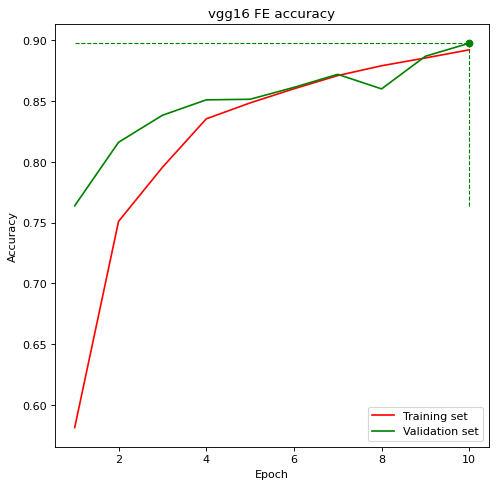

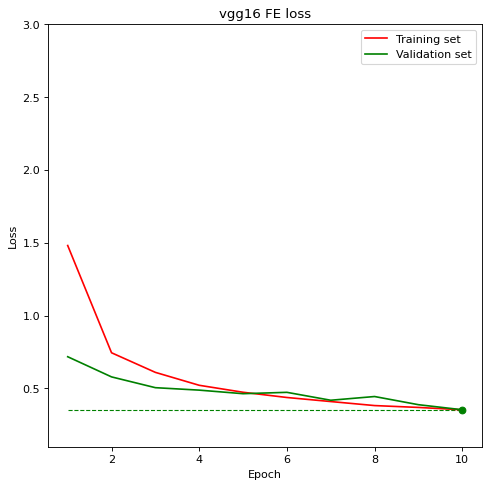

In [ ]:
import matplotlib.pyplot as plt
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('vgg16 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('vgg16 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,3)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
test_predictions = opt_vgg16_fe.predict(test_dataset)  # probabilities for all classes
test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
print(test_predictions)
test_labels = get_all_labels(test_dataset)

m = confusion_matrix(test_labels, test_predictions)


[0 0 0 ... 3 1 1]


In [ ]:
target_names = ['1', '2', '3','4','5','6','7','8','9']

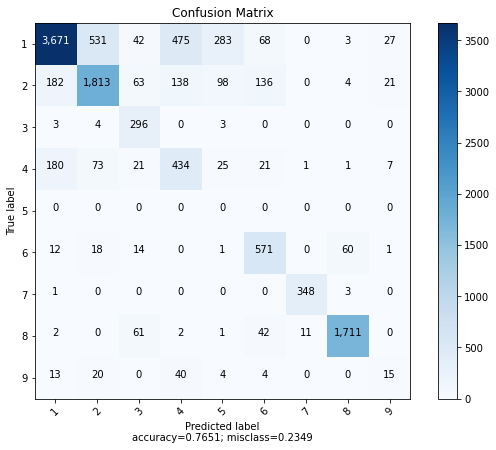

In [ ]:
plot_confusion_matrix(cm           = np.array(m), 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

In [ ]:
print(classification_report(test_labels, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

           1       0.90      0.72      0.80      5100
           2       0.74      0.74      0.74      2455
           3       0.60      0.97      0.74       306
           4       0.40      0.57      0.47       763
           5       0.00      0.00      0.00         0
           6       0.68      0.84      0.75       677
           7       0.97      0.99      0.98       352
           8       0.96      0.93      0.95      1830
           9       0.21      0.16      0.18        96

    accuracy                           0.77     11579
   macro avg       0.61      0.66      0.62     11579
weighted avg       0.82      0.77      0.78     11579



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FINE TUNED vgg16

In [ ]:
vgg16_ft_1layer = models.load_model('vgg16_pretrained_1_best.h5')

In [ ]:
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 9)                 4617      
Total params: 14,981,961
Trainable params: 2,627,081
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)         

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoint = ModelCheckpoint(
        'vgg16_finetuned_2_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft = vgg16_ft_1layer.fit(
        train_dataset,
        steps_per_epoch=len(train_dataset.classes) // BATCH_SIZE,
        epochs=10,
        validation_data=valid_dataset,
        validation_steps = len(valid_dataset.classes) // BATCH_SIZE,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0,
        #class_weight=class_weights,
        )


if not os.path.exists(dir_name):
  os.makedirs(dir_name)
models.save_model(vgg16_pretrained, 'vgg16_finetuned_2.h5')
!cp vgg16_finetuned_2* "/content/drive/MyDrive/MIRCV/model"

Epoch 1/10
137/137 [==============================] - 203s 1s/step - loss: 0.3482 - accuracy: 0.8918 - val_loss: 0.2766 - val_accuracy: 0.9165

Epoch 00001: val_loss improved from inf to 0.27665, saving model to vgg16_finetuned_2_best.h5
Epoch 2/10
137/137 [==============================] - 201s 1s/step - loss: 0.2058 - accuracy: 0.9419 - val_loss: 0.2512 - val_accuracy: 0.9253

Epoch 00002: val_loss improved from 0.27665 to 0.25119, saving model to vgg16_finetuned_2_best.h5
Epoch 3/10
137/137 [==============================] - 199s 1s/step - loss: 0.1659 - accuracy: 0.9573 - val_loss: 0.2516 - val_accuracy: 0.9270

Epoch 00003: val_loss did not improve from 0.25119
Epoch 4/10
137/137 [==============================] - 198s 1s/step - loss: 0.1495 - accuracy: 0.9624 - val_loss: 0.2170 - val_accuracy: 0.9458

Epoch 00004: val_loss improved from 0.25119 to 0.21697, saving model to vgg16_finetuned_2_best.h5
Epoch 5/10
137/137 [==============================] - 206s 2s/step - loss: 0.1286 -

In [ ]:
# History of accuracy and loss
tra_loss_ft = history_ft.history['loss']
tra_acc_ft = history_ft.history['accuracy']
val_loss_ft = history_ft.history['val_loss']
val_acc_ft = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_ft = range(1, len(tra_acc_ft)+1)
end_epoch_ft = len(tra_acc_ft)

# Epoch when reached the validation loss minimum
opt_epoch_ft = val_loss_ft.index(min(val_loss_ft)) + 1

# Loss and accuracy on the validation set
end_val_loss_ft = val_loss_ft[-1]
end_val_acc_ft = val_acc_ft[-1]
opt_val_loss_ft = val_loss_ft[opt_epoch_ft-1]
opt_val_acc_ft = val_acc_ft[opt_epoch_ft-1]

# Loss and accuracy on the test set
opt_vgg16_ft = models.load_model('vgg16_finetuned_2_best.h5')
test_loss_ft, test_acc_ft = vgg16_ft_1layer.evaluate(x=test_dataset, batch_size=250)
opt_test_loss_ft, opt_test_acc_ft = opt_vgg16_ft.evaluate(x=test_dataset,batch_size=250)

print("VGG16 Fine Tuned\n")

print("Epoch [end]: %d" % end_epoch_ft)
print("Epoch [opt]: %d" % opt_epoch_ft)
print("Valid accuracy [end]: %.4f" % end_val_acc_ft)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_ft)
print("Test accuracy [end]:  %.4f" % test_acc_ft)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_ft)
print("Valid loss [end]: %.4f" % end_val_loss_ft)
print("Valid loss [opt]: %.4f" % opt_val_loss_ft)
print("Test loss [end]:  %.4f" % test_loss_ft)
print("Test loss [opt]:  %.4f" % opt_test_loss_ft)

91/91 [==============================] - 26s 284ms/step - loss: 0.6507 - accuracy: 0.8619
VGG16 Fine Tuned

Epoch [end]: 10
Epoch [opt]: 8
Valid accuracy [end]: 0.9629
Valid accuracy [opt]: 0.9626
Test accuracy [end]:  0.8583
Test accuracy [opt]:  0.8619
Valid loss [end]: 0.1694
Valid loss [opt]: 0.1430
Test loss [end]:  0.6910
Test loss [opt]:  0.6507


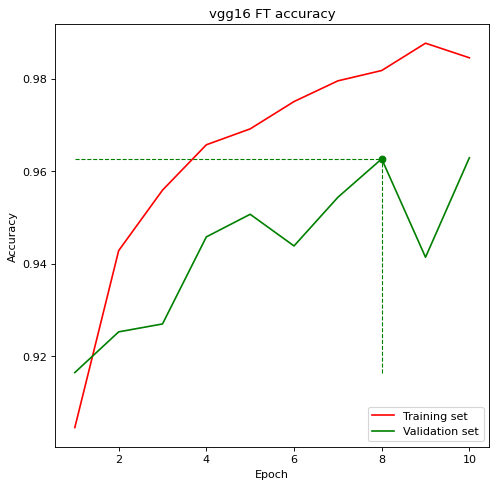

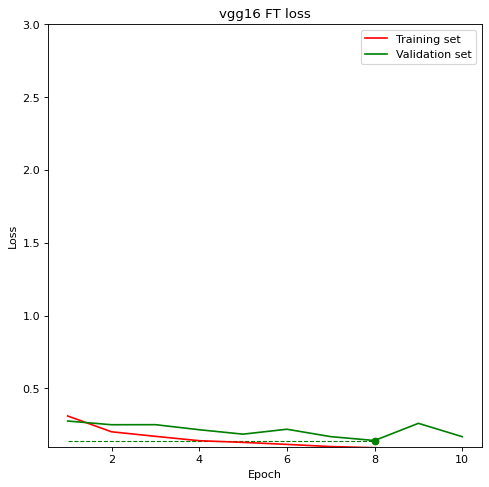

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('vgg16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_ft, tra_acc_ft, 'r', label='Training set')
plt.plot(epochs_ft, val_acc_ft, 'g', label='Validation set')
plt.plot(opt_epoch_ft, val_acc_ft[opt_epoch_ft-1], 'go')
plt.vlines(opt_epoch_ft, min(val_acc_ft), opt_val_acc_ft, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_ft, 1, opt_epoch_ft, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('vgg16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,3)
plt.plot(epochs_ft, tra_loss_ft, 'r', label='Training set')
plt.plot(epochs_ft, val_loss_ft, 'g', label='Validation set')
plt.plot(opt_epoch_ft, val_loss_ft[opt_epoch_ft-1], 'go')
plt.vlines(opt_epoch_ft, min(val_loss_ft), opt_val_loss_ft, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_ft, 1, opt_epoch_ft, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
test_predictions = opt_vgg16_ft.predict(test_dataset)  # probabilities for all classes
test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
test_labels = get_all_labels(test_dataset)

m = confusion_matrix(test_labels, test_predictions)

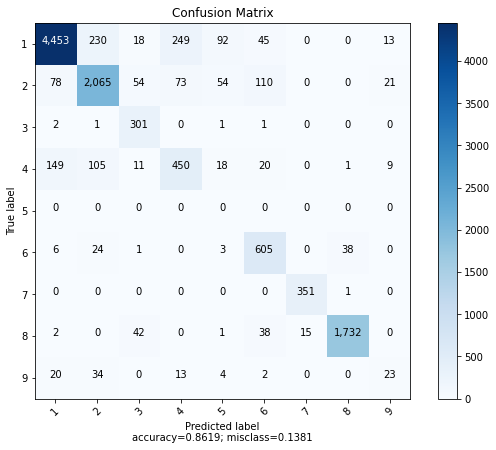

In [ ]:
plot_confusion_matrix(cm           = np.array(m), 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

In [ ]:
print(classification_report(test_labels, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

           1       0.95      0.87      0.91      5100
           2       0.84      0.84      0.84      2455
           3       0.70      0.98      0.82       306
           4       0.57      0.59      0.58       763
           5       0.00      0.00      0.00         0
           6       0.74      0.89      0.81       677
           7       0.96      1.00      0.98       352
           8       0.98      0.95      0.96      1830
           9       0.35      0.24      0.28        96

    accuracy                           0.86     11579
   macro avg       0.68      0.71      0.69     11579
weighted avg       0.88      0.86      0.87     11579



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
opt_vgg16_fe = models.load_model('vgg16_pretrained_1_best.h5')
opt_vgg16_ft = models.load_model('vgg16_finetuned_2_best.h5')

In [ ]:
def prova(dataset):
    number_of_examples = len(dataset.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 
    X=[]
    y=[]
    for i in tqdm(range(0,int(number_of_generator_calls))):
      X.extend(np.array(dataset[i][0]))
      y.extend(np.array(dataset[i][1]))
    y=[int(intero) for intero in y]
    return X,y

In [ ]:
n_queries = 30
k = 91

test_images, test_labels = prova(test_dataset)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
# np.concatenate([images for images, _ in test_dataset])  # get only the images

# query_indexes = [78, 80, 89, 23, 20]
# query_indexes = [14, 78, 79, 12, 18]
query_indexes = [14, 78,  2, 18,  9]
# query_indexes = np.random.choice(len(test_images), n_queries, replace=False)  # get 10 queries at random
query_images = test_images[query_indexes]
query_labels = test_labels[query_indexes]

In [ ]:
n_queries = 30
k = 91
query_indexes = np.random.choice(len(test_images), n_queries, replace=False)  # get 10 queries at random
query_images = test_images[query_indexes]
query_labels = test_labels[query_indexes]

In [ ]:
from PIL import Image, ImageDraw, ImageOps
# utility function to extract and normalize features
def extract_features(feature_extractor, images):
  features = feature_extractor.predict(images, batch_size=BATCH_SIZE)
  features = sklearn.preprocessing.normalize(features)
  return features


# utility function to perform kNN search
def search(query_features, db_features, k):
  scores = np.dot(query_features, db_features.T)  # compute cosine scores
  ranks = np.argsort(-scores, axis=1)  # order for descending score (NOTE the minus sign)

  topk = ranks[:, :k]  # get the top-k indices for each query
  n_queries = len(query_features)
  topk_scores = scores[np.arange(n_queries).reshape(-1, 1), topk]  # get the top-k scores for each query
  return topk, topk_scores


# utility to resize, pad, and write score on images
preview_size = 80
def process_images(image, score, is_relevant):
  x = image.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  # to uint8 [0, 255]
  #image = ((image - 1) * 127.5).astype(np.uint8)
  image=x
  # add a red/green flag
  color = (0, 255, 0) if is_relevant else (255, 0, 0)
  flag = np.full((10, 224, 3), fill_value=color, dtype=image.dtype)
  image = np.concatenate((image, flag), axis=0)

  # resize
  image = Image.fromarray(image).convert('RGBA')
  image.thumbnail((preview_size, preview_size))  # use PIL to resize the image

  # draw score
  draw = ImageDraw.Draw(image)
  draw.text((3, preview_size - 12), f'{score:.2f}', anchor='lt', fill=(255, 255, 255, 255))

  # pad the image with transparency
  image = ImageOps.expand(image, 5, fill=(0, 0, 0, 0))
  image = np.array(image)
  return image

# use np.vectorize to apply custom functions to numpy arrays
np_process_image = np.vectorize(process_images, signature='(h,w,c),(),()->(h1,w1,c1)')


def compute_ap_at_k(ranked_relevance, k):
  # each row in ranked_relevance is a boolean array that indicates whether that 
  # retrieved element is relevant for the query 

  total_relevant_items = ranked_relevance.sum(axis=1)

  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  prec_at_i = ranked_relevance[:, :k].cumsum(axis=1) / np.arange(1, k + 1) 

  # sum of prec_at_i only for relevant, divide for total number of relevant items (for each query)
  aps = (ranked_relevance[:, :k] * prec_at_i).sum(axis=1) / total_relevant_items

  return aps


# utility function to draw knn results for multiple queries
def show_results(images, scores, is_relevant):
  # images has shape (n_queries, k, H, W, C)
  images = np_process_image(images, scores, is_relevant)
  images = np.concatenate(images, axis=1)  # concatenate queries vertically
  images = np.concatenate(images, axis=1)  # concatenate results horizontally
  
  display(Image.fromarray(images))
def show_query(images):
  x = images.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')

  display(Image.fromarray(x))

In [ ]:
def evaluate_knn_search(model, query_images, query_labels, db_images, db_labels, k=None):
  query_features = extract_features(model, query_images)
  db_features = extract_features(model, db_images)

  # get the entire db as result list (for computing mAP)
  rank, ranked_scores = search(query_features, db_features, k=k)
  ranked_labels = db_labels[rank]

  k = len(db_labels) if k is None else k

  # ranked_relevance = whether the retrieved image is relevant w.r.t. the query
  ranked_relevance = ranked_labels == query_labels.reshape(-1, 1)

  ## computation of mAP@k
  aps = compute_ap_at_k(ranked_relevance, k)

  print(f'AP@{k} for each Query:', aps)
  print(f'mAP@{k}:', np.mean(aps))

  k = min(k, 15)  # don't show more than 15 images in colab

  topk = rank[:, :k]
  topk_images = db_images[topk]
  topk_scores = ranked_scores[:, :k]
  topk_is_relevant = ranked_relevance[:,:k]
  
  #""" Sklearn meanAP (normalizes score to consider only k retrieved elements)  
  aps = [sklearn.metrics.average_precision_score(l, s) for l,s in zip(topk_is_relevant, topk_scores)]
  print('APs per Query:', aps)
  print('mAP:', np.mean(aps))
  #"""

  show_results(topk_images, topk_scores, topk_is_relevant)


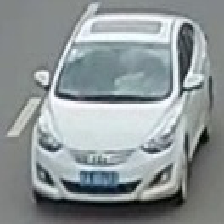

0


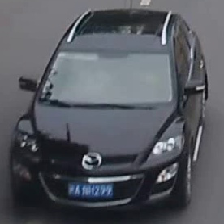

1


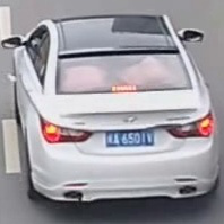

0


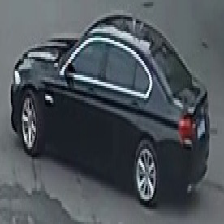

0


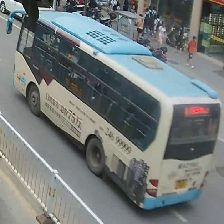

6


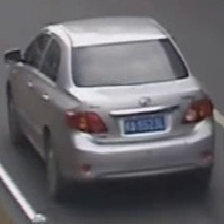

0


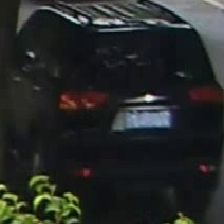

1


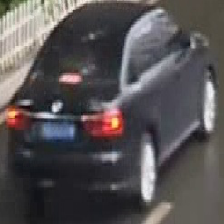

0


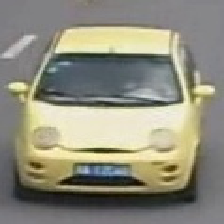

3


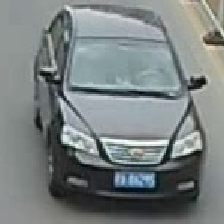

0


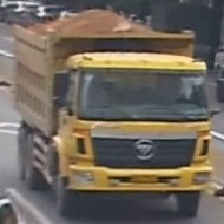

7


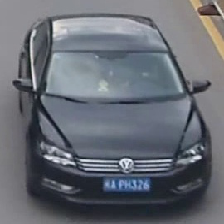

0


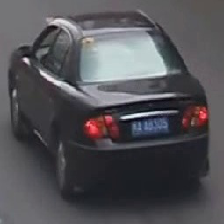

0


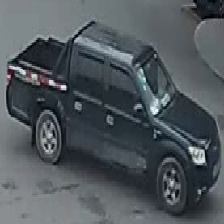

5


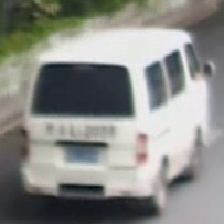

2


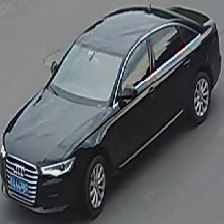

0


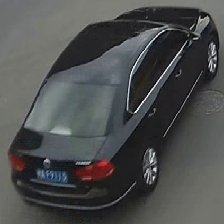

0


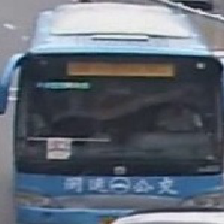

6


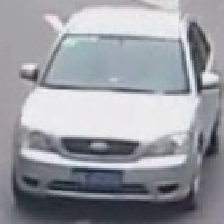

0


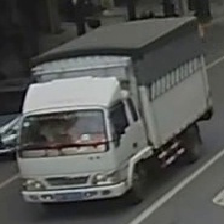

7


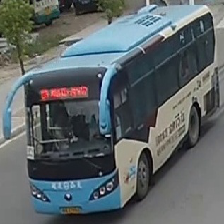

6


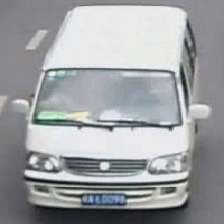

2


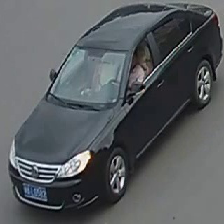

0


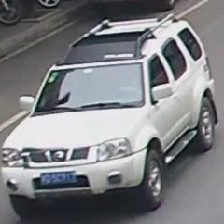

1


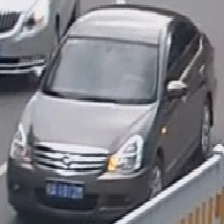

0


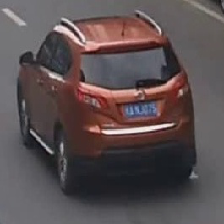

1


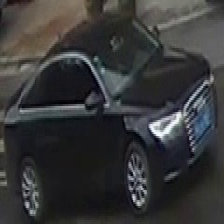

0


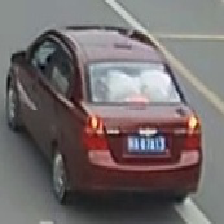

0


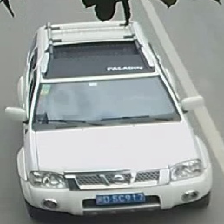

1


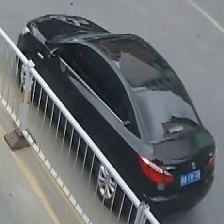

0


In [ ]:
for i,img in enumerate(query_images):
  show_query(img)
  print(query_labels[i])

In [ ]:
pretrained_feature_extractor = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg')
new_classifier_feature_extractor = Model(inputs=opt_vgg16_fe.input, outputs=opt_vgg16_fe.get_layer('classifier_hidden').output)
finetuned_feature_extractor = Model(inputs=opt_vgg16_ft.input, outputs=opt_vgg16_ft.get_layer('gap').output)

print('\nModel pretrained on ImageNet (GAP)')
evaluate_knn_search(pretrained_feature_extractor, query_images, query_labels, test_images, test_labels, k)

print('\nModel frozen with top trained on CNRPark (Classifier Hidden 256D)')
evaluate_knn_search(new_classifier_feature_extractor, query_images, query_labels, test_images, test_labels, k)

print('\nModel finetuned on CNRPark (GAP)')
evaluate_knn_search(finetuned_feature_extractor, query_images, query_labels, test_images, test_labels, k)

Output hidden; open in https://colab.research.google.com to view.